In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
   
def transform3(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[i] = np.dot(points[i], poses[i].T)
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = + pmin[1] / maxxy

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

In [56]:
sequence = 6

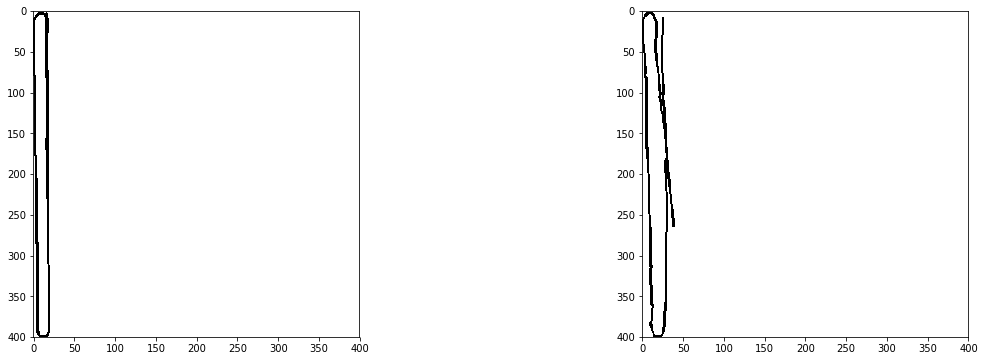

In [57]:
folder = '/data/urbinn/datasets/urb_trajectory_output'
#folder = '/home/jeroen/notebooks/urb/resultsba'
keyframeids, frameids, poses = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

posesold = poses
points = transform(poses[:])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

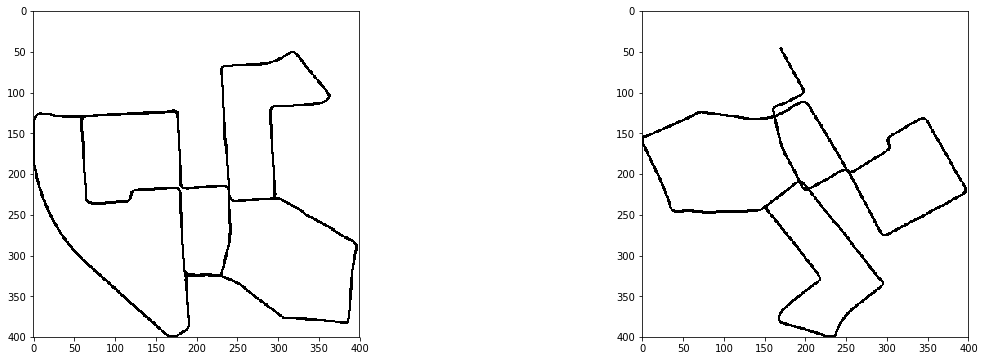

In [49]:
folder = '/data/urbinn/datasets/urb_trajectory_rotationfixed'
folder = '/home/jeroen/notebooks/urb/resultsba'
keyframeids, frameids, poses = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

posesnew = poses
points = transform(poses[:3281])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

In [44]:
for i, xy in enumerate(coords):
    print(i, xy[0], xy[1])

0 176.19717191 347.889010628
1 176.278363594 347.429584813
2 176.376395047 346.964836124
3 176.467690266 346.497511355
4 176.56734492 346.023468575
5 176.668088922 345.55489634
6 176.766826936 345.073542251
7 176.862517213 344.581658802
8 176.961136545 344.090660149
9 177.053284643 343.590388843
10 177.139644771 343.087174333
11 177.23045364 342.5732668
12 177.32060081 342.042397137
13 177.408201665 341.493535508
14 177.49054781 340.932442632
15 177.575538642 340.360517701
16 177.66485851 339.780177035
17 177.756929684 339.200538121
18 177.849736049 338.60513964
19 177.951605621 337.99667602
20 178.055772108 337.366517379
21 178.157208326 336.716584834
22 178.258767987 336.05267798
23 178.367693278 335.390114063
24 178.473558409 334.707881254
25 178.585161755 334.009815274
26 178.705554852 333.304643608
27 178.836396086 332.581871875
28 178.959291372 331.844494572
29 179.082486412 331.087803648
30 179.205880659 330.326409063
31 179.330279116 329.546196386
32 179.456589998 328.758049848

1398 312.857369157 226.137643526
1399 311.984259147 226.000034881
1400 311.091529687 225.856138595
1401 310.189159078 225.723829757
1402 309.307462581 225.588567455
1403 308.416259171 225.45648399
1404 307.521731789 225.319481145
1405 306.631192005 225.189135745
1406 305.743050861 225.058367646
1407 304.844856754 224.923352894
1408 303.947209195 224.785083231
1409 303.056297205 224.648195639
1410 302.169827787 224.513910567
1411 301.270996918 224.380099282
1412 300.372608263 224.248541332
1413 299.489470294 224.107604058
1414 298.604475681 223.975806057
1415 297.714917996 223.846451046
1416 296.83199344 223.708848584
1417 295.933300423 223.560729666
1418 295.047479711 223.429694244
1419 294.148663378 223.287241236
1420 293.26569881 223.154149383
1421 292.376046167 223.020599172
1422 291.493530979 222.89472449
1423 290.599549082 222.769329904
1424 289.7359666 222.663735109
1425 288.829773018 222.523113776
1426 287.934368804 222.380132679
1427 287.061327241 222.25884052
1428 286.17100499

2756 195.897963062 39.119981503
2757 195.896163132 38.1999599926
2758 195.892125438 37.2839530453
2759 195.891814036 36.3590613038
2760 195.885073346 35.4525489307


In [7]:
p = posesold.copy()
for i in range(1, len(p)):
    p[i] = np.dot( p[i-1], p[i] )
pterug = p.copy()
for i in range(len(p)-1, 0, -1):
    pterug[i] = np.dot( np.linalg.pinv(pterug[i-1]), pterug[i] )

print(posesold[:,2,3])
pterug[:,2,3]

[  0.00000000e+00  -2.07336418e+00  -2.68131517e+00  -1.38630049e+00
  -1.71953896e+00  -7.78647378e-01  -2.13931223e+00  -4.88609967e+00
  -3.31735302e+00  -5.60277641e+00  -1.65735413e+00  -5.06530295e+00
  -1.74021325e+00  -2.31040893e+00  -2.60899694e+00  -2.08690589e+00
  -2.26365918e+00  -3.44459708e+00  -2.57340686e+00  -3.33937555e+00
  -5.04940771e+00  -2.38680014e+00  -4.79259578e+00  -2.15647040e+00
  -4.57132255e+00  -2.44478461e+00  -9.51119927e-01  -9.09010689e-01
  -9.16197586e-01  -2.32931136e+00  -1.75727663e+00  -1.51985933e+00
  -1.74599157e+00  -4.83382634e+00  -5.38696493e+00  -6.07219884e+00
  -3.25264658e+00  -1.18368449e+00  -3.93454632e+00  -2.34339743e+00
  -3.23300438e+00  -1.78116095e+00  -1.92297178e+00  -3.52239696e+00
  -2.80500435e+00  -1.58514466e+00  -2.64071256e+00  -3.91169382e+00
  -3.38211759e+00  -1.69640256e+00  -2.59661275e+00  -8.65156103e+00
  -3.18415480e+00  -1.56941476e+00  -3.08423805e+00  -2.77156244e+00
  -3.90212467e+00  -3.05001187e+00

array([  0.00000000e+00,  -2.07336418e+00,  -2.68131517e+00,
        -1.38630049e+00,  -1.71953896e+00,  -7.78647378e-01,
        -2.13931223e+00,  -4.88609967e+00,  -3.31735302e+00,
        -5.60277641e+00,  -1.65735413e+00,  -5.06530295e+00,
        -1.74021325e+00,  -2.31040893e+00,  -2.60899694e+00,
        -2.08690589e+00,  -2.26365918e+00,  -3.44459708e+00,
        -2.57340686e+00,  -3.33937555e+00,  -5.04940771e+00,
        -2.38680014e+00,  -4.79259578e+00,  -2.15647040e+00,
        -4.57132255e+00,  -2.44478461e+00,  -9.51119927e-01,
        -9.09010689e-01,  -9.16197586e-01,  -2.32931136e+00,
        -1.75727663e+00,  -1.51985933e+00,  -1.74599157e+00,
        -4.83382634e+00,  -5.38696493e+00,  -6.07219884e+00,
        -3.25264658e+00,  -1.18368449e+00,  -3.93454632e+00,
        -2.34339743e+00,  -3.23300438e+00,  -1.78116095e+00,
        -1.92297178e+00,  -3.52239696e+00,  -2.80500435e+00,
        -1.58514466e+00,  -2.64071256e+00,  -3.91169382e+00,
        -3.38211759e+00,

Show the affine world coodinates for the first 3 poses

In [8]:
points[:3]

array([[-22.84171697,  11.86033632,  15.10179354,   1.        ],
       [-22.84549591,  11.85670979,  15.19516811,   1.        ],
       [-22.85233309,  11.84735372,  15.2951404 ,   1.        ]])

show the converted x,y coordinates to plot the trajectory

In [9]:
coords[:3]

array([[ 324.56119819,   75.39274711,    1.        ],
       [ 324.55470624,   75.23233609,    1.        ],
       [ 324.54296043,   75.06059063,    1.        ]])

In [43]:
show(draw_frame(frame[3281]))

NameError: name 'frame' is not defined